In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [0]:

device = torch.device("cuda:0")

In [5]:
data_train = dset.SVHN('./', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./',  download=True,split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler_loss=False):    
    train_loss_history = []
    train_acc_history = []

    val_loss_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += float(loss_value)

        train_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        
        val_loss, val_accuracy = compute_loss_accuracy(model, val_loader)
        
        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        
        print("Epoch #%s - train loss: %f, accuracy: %f | val loss: %f, accuracy: %f" % (epoch, train_loss, train_accuracy, val_loss, val_accuracy))
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

  
def compute_loss_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    
    loss_accum = 0.0
    correct = 0.0
    total = 0.0
    for i, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        y_probs = model(x_gpu)        
        y_hat = torch.argmax(y_probs, 1)
        
        loss_value = loss(y_probs, y_gpu)
        loss_accum += float(loss_value)
        
        correct += float(torch.sum(y_hat == y_gpu))
        total += y_gpu.shape[0]
        
    return loss_accum / (i + 1), correct / total

    
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch #0 - train loss: 1.372403, accuracy: 0.544125 | val loss: 0.884212, accuracy: 0.728824
Epoch #1 - train loss: 0.699589, accuracy: 0.787121 | val loss: 0.660565, accuracy: 0.797147
Epoch #2 - train loss: 0.604466, accuracy: 0.819541 | val loss: 0.670184, accuracy: 0.792983
Epoch #3 - train loss: 0.556951, accuracy: 0.833686 | val loss: 0.541517, accuracy: 0.843151
Epoch #4 - train loss: 0.526996, accuracy: 0.844504 | val loss: 0.565400, accuracy: 0.834073
CPU times: user 1min 17s, sys: 5.05 s, total: 1min 22s
Wall time: 1min 23s


In [10]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', download=True,
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Using downloaded and verified file: ./train_32x32.mat


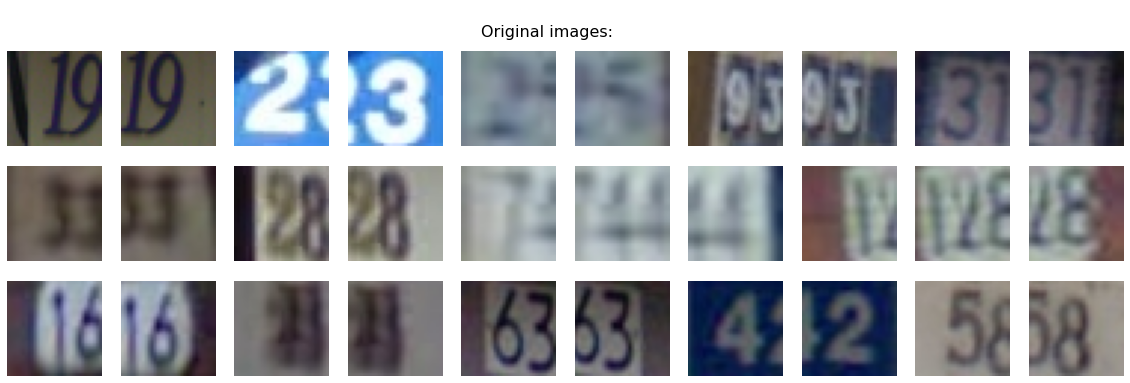

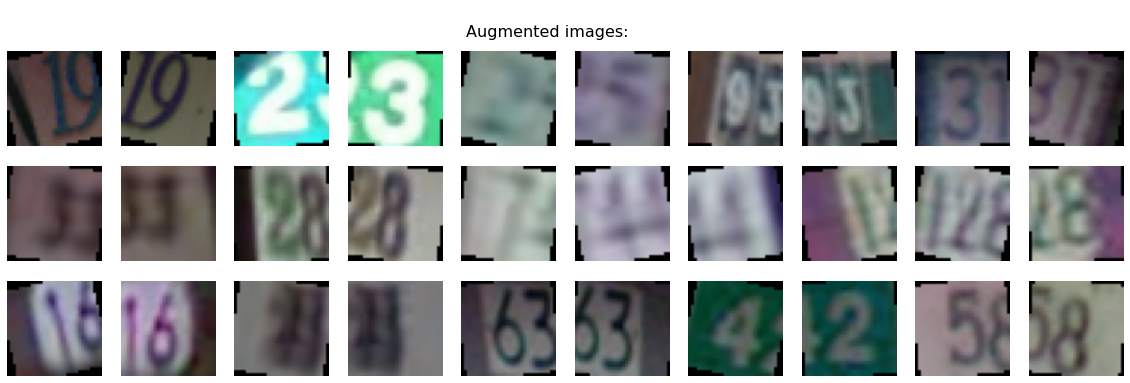

In [11]:
rows = 3
cols = 10

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nOriginal images:', fontsize=16)

for i, (x, y) in enumerate(dset.SVHN('./')):
    if i == rows * cols:
        break
    plt.subplot(rows, cols, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')


# -----------------------------------------------------------------
    
    
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15, resample=PIL.Image.BILINEAR)
])        
data_aug_vis = dset.SVHN('./', transform=tfs)

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nAugmented images:', fontsize=16)

for i, (x, y) in enumerate(data_aug_vis):
    if i == rows * cols:
        break
    plt.subplot(rows, cols, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', transform=tfs)
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

In [14]:
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Epoch #0 - train loss: 0.605959, accuracy: 0.815684 | val loss: 0.541278, accuracy: 0.840830
Epoch #1 - train loss: 0.565727, accuracy: 0.829215 | val loss: 0.554505, accuracy: 0.841581
Epoch #2 - train loss: 0.545836, accuracy: 0.836143 | val loss: 0.544205, accuracy: 0.843765
Epoch #3 - train loss: 0.528005, accuracy: 0.840545 | val loss: 0.487936, accuracy: 0.861170
Epoch #4 - train loss: 0.514129, accuracy: 0.844146 | val loss: 0.553092, accuracy: 0.832025
CPU times: user 3min 2s, sys: 7.24 s, total: 3min 9s
Wall time: 3min 9s


In [0]:
# Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    # C1
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
    nn.Tanh(),
    
    # S2
    nn.MaxPool2d(kernel_size=2),
    
    # C3
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.Tanh(),
    
    # S4
    nn.MaxPool2d(kernel_size=2),
    
    Flattener(),

    # F5
    nn.Linear(in_features=5*5*16, out_features=120),
    nn.Tanh(),
    
    # F6
    nn.Linear(in_features=120, out_features=84),
    nn.Tanh(),
    
    # O7
    nn.Linear(in_features=84, out_features=10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [16]:
# Let's train it!
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Epoch #0 - train loss: 1.257956, accuracy: 0.577791 | val loss: 0.558415, accuracy: 0.832503
Epoch #1 - train loss: 0.559670, accuracy: 0.829591 | val loss: 0.472089, accuracy: 0.855027
Epoch #2 - train loss: 0.483091, accuracy: 0.853462 | val loss: 0.459298, accuracy: 0.860487
Epoch #3 - train loss: 0.441084, accuracy: 0.865850 | val loss: 0.412966, accuracy: 0.873456
Epoch #4 - train loss: 0.415867, accuracy: 0.872539 | val loss: 0.386445, accuracy: 0.882192
Epoch #5 - train loss: 0.393990, accuracy: 0.878408 | val loss: 0.390606, accuracy: 0.882465
Epoch #6 - train loss: 0.374030, accuracy: 0.885336 | val loss: 0.389688, accuracy: 0.882261
Epoch #7 - train loss: 0.363061, accuracy: 0.887844 | val loss: 0.367054, accuracy: 0.887789
Epoch #8 - train loss: 0.347221, accuracy: 0.893185 | val loss: 0.370306, accuracy: 0.889837
Epoch #9 - train loss: 0.335515, accuracy: 0.897144 | val loss: 0.370043, accuracy: 0.889427
CPU times: user 5min 48s, sys: 6.68 s, total: 5min 54s
Wall time: 5min

In [0]:
##Свободное упражнение - догоним и перегоним LeNet!¶
##Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

##Что можно и нужно попробовать:

##BatchNormalization (для convolution layers он в PyTorch называется batchnorm2d)
##Изменить количество слоев и их толщину
##Изменять количество эпох тренировки
#Попробовать и другие агментации

In [19]:
model = nn.Sequential(
    # 32x32@3 => 32x32@16
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(inplace=True),    
    
    # 32x32@16 => 16x16@16
    nn.MaxPool2d(kernel_size=2),
    
    # 16x16@16 => 14x14@32
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(inplace=True),    
    
    # 14x14@32 => 7x7@32
    nn.MaxPool2d(kernel_size=2),
    
    # 7x7@32 => 5x5@64
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    
    Flattener(),

    nn.Linear(in_features=5*5*64, out_features=128),    
    nn.BatchNorm1d(num_features=128),
    nn.ReLU(inplace=True),
    
    nn.Linear(in_features=128, out_features=10)
)

model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, 10, \
                                                                                             scheduler=scheduler, scheduler_loss=True)

Epoch #0 - train loss: 0.616416, accuracy: 0.810668 | val loss: 0.365460, accuracy: 0.892089
Epoch #1 - train loss: 0.383384, accuracy: 0.883271 | val loss: 0.324741, accuracy: 0.903761
Epoch #2 - train loss: 0.342242, accuracy: 0.897280 | val loss: 0.295890, accuracy: 0.909972
Epoch #3 - train loss: 0.319033, accuracy: 0.903679 | val loss: 0.307421, accuracy: 0.906696
Epoch #4 - train loss: 0.302858, accuracy: 0.909344 | val loss: 0.292484, accuracy: 0.913863
Epoch #5 - train loss: 0.289472, accuracy: 0.912842 | val loss: 0.298889, accuracy: 0.911610
Epoch #6 - train loss: 0.281131, accuracy: 0.915521 | val loss: 0.282135, accuracy: 0.915432
Epoch #7 - train loss: 0.276916, accuracy: 0.916886 | val loss: 0.273566, accuracy: 0.919869
Epoch #8 - train loss: 0.269675, accuracy: 0.919274 | val loss: 0.267580, accuracy: 0.919459
Epoch #9 - train loss: 0.266125, accuracy: 0.921254 | val loss: 0.277098, accuracy: 0.919255
CPU times: user 6min 10s, sys: 5.95 s, total: 6min 16s
Wall time: 6min

In [0]:
HyperParams = namedtuple("Hyperparams", ['learning_rate', 'reg_strength', 'anneal_factor', 'anneal_patience', 'epochs'])
RunResult = namedtuple("RunResult", ['model', 'train_loss_history', 'train_acc_history', 'val_loss_history', 'val_acc_history', 'final_val_accuracy'])

def search(stats, learning_rates, reg_strengths, anneal_factor=0.333, anneal_patience=3, epochs=15):            
    for learning_rate in learning_rates:
        for reg_strength in reg_strengths:            
            
            model = nn.Sequential(
                # 32x32@3 => 32x32@16
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=16),
                nn.ReLU(inplace=True),    

                # 32x32@16 => 16x16@16
                nn.MaxPool2d(kernel_size=2),

                # 16x16@16 => 14x14@32
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                nn.BatchNorm2d(num_features=32),
                nn.ReLU(inplace=True),    

                # 14x14@32 => 7x7@32
                nn.MaxPool2d(kernel_size=2),

                # 7x7@32 => 5x5@64
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(inplace=True),

                Flattener(),

                nn.Linear(in_features=5*5*64, out_features=128),    
                nn.BatchNorm1d(num_features=128),
                nn.ReLU(inplace=True),

                nn.Linear(in_features=128, out_features=10)
            )
    
            model.type(torch.cuda.FloatTensor)
            model.to(device)

            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_strength)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=anneal_factor, patience=anneal_patience, verbose=True)
            
            key = HyperParams(learning_rate, reg_strength, anneal_factor, anneal_patience, epochs)
            
            print('Training model: %s' % str(key))
            
            results = train_model(model, train_aug_loader, val_loader, loss, optimizer, epochs, scheduler=scheduler, scheduler_loss=True)
            train_loss_history, train_acc_history, val_loss_history, val_acc_history = results
            final_val_accuracy = val_acc_history[-1]
                                    
            value = RunResult(model, train_loss_history, train_acc_history, val_loss_history, val_acc_history, final_val_accuracy)            
            stats[key] = value
            
            print('\n')
    

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {}

In [21]:
learning_rates = [1e-3]
reg_strengths = [1e-4]

search(run_record, learning_rates, reg_strengths, epochs=30)

Training model: Hyperparams(learning_rate=0.001, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=30)
Epoch #0 - train loss: 0.636372, accuracy: 0.803399 | val loss: 0.397711, accuracy: 0.877483
Epoch #1 - train loss: 0.380194, accuracy: 0.884500 | val loss: 0.316122, accuracy: 0.904034
Epoch #2 - train loss: 0.316538, accuracy: 0.904191 | val loss: 0.298661, accuracy: 0.911815
Epoch #3 - train loss: 0.283482, accuracy: 0.913985 | val loss: 0.274059, accuracy: 0.920210
Epoch #4 - train loss: 0.259981, accuracy: 0.921629 | val loss: 0.269384, accuracy: 0.921917
Epoch #5 - train loss: 0.237630, accuracy: 0.928489 | val loss: 0.265354, accuracy: 0.922463
Epoch #6 - train loss: 0.219356, accuracy: 0.934102 | val loss: 0.267774, accuracy: 0.924306
Epoch #7 - train loss: 0.204335, accuracy: 0.938129 | val loss: 0.265005, accuracy: 0.924169
Epoch #8 - train loss: 0.192648, accuracy: 0.939699 | val loss: 0.264145, accuracy: 0.925193
Epoch #9 - train loss: 0.180628, accuracy:

In [22]:
run_record

{Hyperparams(learning_rate=0.001, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=30): RunResult(model=Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Flattener()
  (12): Linear(in_features=1600, out_features=128, bias=True)
  (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1

In [23]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

best_model = run_record[best_hyperparams].model

Best validation accuracy: 0.933383, best hyperparams: Hyperparams(learning_rate=0.001, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=30)


In [24]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_loss, test_accuracy = compute_loss_accuracy(best_model, test_loader)
print("Test loss: %f, accuracy: %f" % (test_loss, test_accuracy))

Test loss: 0.281341, accuracy: 0.930701
